In [6]:
import load_ship_data
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import mpp_classifiers as mpp
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import load_flat_ncolor_data as loader
from sklearn.metrics import confusion_matrix

In [7]:
# set seed
np.random.seed(522)
# load data
path = './data/shipsnet.json'
train, test, val = load_ship_data.load_data_train_test_split(path)

train, labels_tr = train
test, labels_te = test
val, labels_val = val

# completely flatten
train_flat = train.reshape(train.shape[0], 19200)
test_flat = test.reshape(test.shape[0], 19200)
val_flat = val.reshape(val.shape[0], 19200)

# flatten pixels only (for color reduction)
train_rgb = train.reshape(train.shape[0], 3, 6400)
test_rgb = test.reshape(test.shape[0], 3, 6400)
val_rgb = val.reshape(val.shape[0], 3, 6400)
# move channels to last axis
train_rgb = np.swapaxes(train_rgb, 1, 2)
test_rgb = np.swapaxes(test_rgb, 1, 2)
val_rgb = np.swapaxes(test_rgb, 1, 2)

# combine train and val for use in sklearn's KFold function
samples = np.concatenate((train_flat, val_flat), axis=0)
labels = np.concatenate((labels_tr, labels_val), axis=None)

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(samples, labels)

Training Set Data Length:  2800   Label Length:  2800
TestingSet Set Data Length:  600  Label Length:  600
Validation Set Data Length:  600  Label Length:  600


5

# 2-Color Pictures with Kmeans Color Reduction

Only run the below if you want to replace the samples with 2-color samples. The accuracies are nearly identical, suggesting that more than 2 colors is almost entirely noise for the purposes of this classification, though how much this affects accuracy is somewhat dependent on the classifier.

In [ ]:
# alternate with 2 colors
np.random.seed(522)
train, test, labels_tr, labels_te = loader.load_data_and_convert(path, 2)

samples = train.reshape(train.shape[0], 19200)
labels = test.reshape(test.shape[0], 19200)

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(samples, labels)

# K-means

K-means predictions are absolutely horrendous. This is not particulary surprising, as k-means is attempting to cluster like pixels together across all of the images and 3 color channels. That's a fine idea, but is not capable of taking rotation of images into account.

However, k-means can also be used as a form of dimensionality reduction by segmenting images into clusters before applying a different algorithm. This application can do something like clearly split ocean from a ship.

In [31]:
accuracies = np.zeros((5, 3))
times = []
for i, (train_idx, test_idx) in enumerate(skf.split(samples, labels)):
    start_time = time.time()
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=522)
    train_n, test_n = samples[train_idx], samples[test_idx]
    labels_tr_n, labels_te_n = labels[train_idx], labels[test_idx]
    kmeans.fit(train_n)
    results = kmeans.predict(test_n)
    acc = np.mean(results == labels_te_n)
    acc0_idx = np.where(results == 0)
    acc1_idx = np.where(results == 1)
    acc0 = np.mean(results[acc0_idx] == labels_te_n[acc0_idx])
    acc1 = np.mean(results[acc1_idx] == labels_te_n[acc1_idx])
    accs = [acc, acc0, acc1]
    if acc < 0.5: accs = [1 - x for x in accs]
    accuracies[i, :] = np.array(accs)
    times.append(time.time() - start_time)

print(f'{round(np.mean(np.array(times)), 2)} seconds')
print([round(x, 4) for x in np.mean(accuracies, axis=0)])
results = kmeans.predict(test_flat)
np.save('./data/kmeans_test_results.npy', results)

6.99 seconds
[0.5353, 0.6926, 0.3922]


In [39]:
pca = PCA(n_components = 2, svd_solver = 'full')
pca.fit(samples)

accuracies = np.zeros((5, 3))
times = []
for i, (train_idx, test_idx) in enumerate(skf.split(samples, labels)):
    start_time = time.time()
    kmeans = KMeans(n_clusters=2, n_init=100, random_state=522)
    train_n, test_n = pca.transform(samples[train_idx]), pca.transform(samples[test_idx])
    labels_tr_n, labels_te_n = labels[train_idx], labels[test_idx]
    kmeans.fit(train_n)
    results = kmeans.predict(test_n)
    acc = np.mean(results == labels_te_n)
    acc0_idx = np.where(results == 0)
    acc1_idx = np.where(results == 1)
    acc0 = np.mean(results[acc0_idx] == labels_te_n[acc0_idx])
    acc1 = np.mean(results[acc1_idx] == labels_te_n[acc1_idx])
    accs = [acc, acc0, acc1]
    if acc < 0.5: accs = [1 - x for x in accs]
    accuracies[i, :] = np.array(accs)
    times.append(time.time() - start_time)

end_time = time.time() - start_time
print(f'{round(np.mean(np.array(times)), 2)} seconds')
print([round(x, 4) for x in np.mean(accuracies, axis=0)])

1.08 seconds
[0.5362, 0.592, 0.4932]


In [40]:
pca = PCA(n_components = 245, svd_solver = 'full')
pca.fit(samples)

accuracies = np.zeros((5, 3))
times = []
for i, (train_idx, test_idx) in enumerate(skf.split(samples, labels)):
    start_time = time.time()
    kmeans = KMeans(n_clusters=2, n_init=100, random_state=522)
    train_n, test_n = pca.transform(samples[train_idx]), pca.transform(samples[test_idx])
    labels_tr_n, labels_te_n = labels[train_idx], labels[test_idx]
    kmeans.fit(train_n)
    results = kmeans.predict(test_n)
    acc = np.mean(results == labels_te_n)
    acc0_idx = np.where(results == 0)
    acc1_idx = np.where(results == 1)
    acc0 = np.mean(results[acc0_idx] == labels_te_n[acc0_idx])
    acc1 = np.mean(results[acc1_idx] == labels_te_n[acc1_idx])
    accs = [acc, acc0, acc1]
    if acc < 0.5: accs = [1 - x for x in accs]
    accuracies[i, :] = np.array(accs)
    times.append(time.time() - start_time)

end_time = time.time() - start_time
print(f'{round(np.mean(np.array(times)), 2)} seconds')
print([round(x, 4) for x in np.mean(accuracies, axis=0)])

2.28 seconds
[0.5353, 0.6933, 0.3916]


# WTA

In [34]:
accuracies = np.zeros((5, 3))
times = []
for i, (train_idx, test_idx) in enumerate(skf.split(samples, labels)):
    start_time = time.time()
    kmeans = MiniBatchKMeans(n_clusters=2, n_init=100, random_state=522)
    train_n, test_n = samples[train_idx], samples[test_idx]
    labels_tr_n, labels_te_n = labels[train_idx], labels[test_idx]
    kmeans.fit(train_n)
    results = kmeans.predict(test_n)
    acc = np.mean(results == labels_te_n)
    acc0_idx = np.where(results == 0)
    acc1_idx = np.where(results == 1)
    acc0 = np.mean(results[acc0_idx] == labels_te_n[acc0_idx])
    acc1 = np.mean(results[acc1_idx] == labels_te_n[acc1_idx])
    accs = [acc, acc0, acc1]
    if acc < 0.5: accs = [1 - x for x in accs]
    accuracies[i, :] = np.array(accs)
    times.append(time.time() - start_time)

print(f'{round(np.mean(np.array(times)), 2)} seconds')
print([round(x, 4) for x in np.mean(accuracies, axis=0)])

8.06 seconds
[0.5265, 0.3674, 0.6677]


In [35]:
pca = PCA(n_components = 2, svd_solver = 'full')
pca.fit(samples)

accuracies = np.zeros((5, 3))
times = []
for i, (train_idx, test_idx) in enumerate(skf.split(samples, labels)):
    start_time = time.time()
    MiniBatchkmeans = KMeans(n_clusters=2, n_init=100, random_state=522)
    train_n, test_n = pca.transform(samples[train_idx]), pca.transform(samples[test_idx])
    labels_tr_n, labels_te_n = labels[train_idx], labels[test_idx]
    kmeans.fit(train_n)
    results = kmeans.predict(test_n)
    acc = np.mean(results == labels_te_n)
    acc0_idx = np.where(results == 0)
    acc1_idx = np.where(results == 1)
    acc0 = np.mean(results[acc0_idx] == labels_te_n[acc0_idx])
    acc1 = np.mean(results[acc1_idx] == labels_te_n[acc1_idx])
    accs = [acc, acc0, acc1]
    if acc < 0.5: accs = [1 - x for x in accs]
    accuracies[i, :] = np.array(accs)
    times.append(time.time() - start_time)

end_time = time.time() - start_time
print(f'{round(np.mean(np.array(times)), 2)} seconds')
print([round(x, 4) for x in np.mean(accuracies, axis=0)])

0.46 seconds
[0.5262, 0.3791, 0.6864]


In [36]:
pca = PCA(n_components = 245, svd_solver = 'full')
pca.fit(samples)

accuracies = np.zeros((5, 3))
times = []
for i, (train_idx, test_idx) in enumerate(skf.split(samples, labels)):
    start_time = time.time()
    MiniBatchkmeans = KMeans(n_clusters=2, n_init=100, random_state=522)
    train_n, test_n = pca.transform(samples[train_idx]), pca.transform(samples[test_idx])
    labels_tr_n, labels_te_n = labels[train_idx], labels[test_idx]
    kmeans.fit(train_n)
    results = kmeans.predict(test_n)
    acc = np.mean(results == labels_te_n)
    acc0_idx = np.where(results == 0)
    acc1_idx = np.where(results == 1)
    acc0 = np.mean(results[acc0_idx] == labels_te_n[acc0_idx])
    acc1 = np.mean(results[acc1_idx] == labels_te_n[acc1_idx])
    accs = [acc, acc0, acc1]
    if acc < 0.5: accs = [1 - x for x in accs]
    accuracies[i, :] = np.array(accs)
    times.append(time.time() - start_time)

end_time = time.time() - start_time
print(f'{round(np.mean(np.array(times)), 2)} seconds')
print([round(x, 4) for x in np.mean(accuracies, axis=0)])

0.94 seconds
[0.5238, 0.3789, 0.6868]


## n-color K-means

In [4]:
def images_to_n_colors(images, n_colors, n_subpixels=1000, sample_number=None):
    kmeans = KMeans(n_clusters=n_colors, random_state=522)
    all_centers, all_labels = [], []
    num_imgs = images.shape[0]
    for i in range(num_imgs):
        if sample_number is not None:
            if i < sample_number: continue
        img = images[i, :] / 255
        img_sample = shuffle(img, random_state=522)[:n_subpixels]
        kmeans.fit(img_sample)
        labels = kmeans.predict(img)
        if sample_number is not None:
            return(kmeans, labels)
        else:
            all_centers.append(kmeans.cluster_centers_)
            all_labels.append(labels)
    return(all_centers, all_labels)
        
def recreate_image(clusters, labels, n_colors, flat=False):
    img = np.zeros((80, 80, 3))
    label_idx = 0
    for i in range(80):
        for j in range(80):
            img[i][j] = clusters[labels[label_idx]]
            #img[i][j] = labels[label_idx] / n_colors   # grayscale
            label_idx += 1
    if flat == True:
        return img.reshape(19200)
    else:
        return img

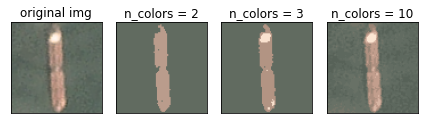

1


In [5]:
fig, axes = plt.subplots(1, 4)
n_colors = [2, 3, 10]
sample_number = 5
n_subpixels = 1000
for i, ax in enumerate(axes):
    if i == 0:
        ax.imshow(test_rgb[sample_number].reshape(80, 80, 3) / 255)
        ax.set_title('original img')
    else:
        kmeans, labels = images_to_n_colors(test_rgb, n_colors[i-1], n_subpixels, sample_number)
        ax.imshow(recreate_image(kmeans.cluster_centers_, labels, n_colors[i-1]))
        ax.set_title(f'n_colors = {str(n_colors[i-1])}')
    ax.set_xticks([])
    ax.set_yticks([])
        
plt.tight_layout()
plt.show()
print(labels_te[sample_number])

# PCA Visualization

Below is the code for a scree plot to see what makes sense for a good number of PCs.

In [11]:
pca = PCA(n_components = 1000, svd_solver = 'full')
pca.fit(samples)

PCA(n_components=1000, svd_solver='full')

In [27]:
cum_pcs = np.zeros(1000)
total = 0
for i in range(1000):
    total += pca.explained_variance_ratio_[i]
    cum_pcs[i] = total

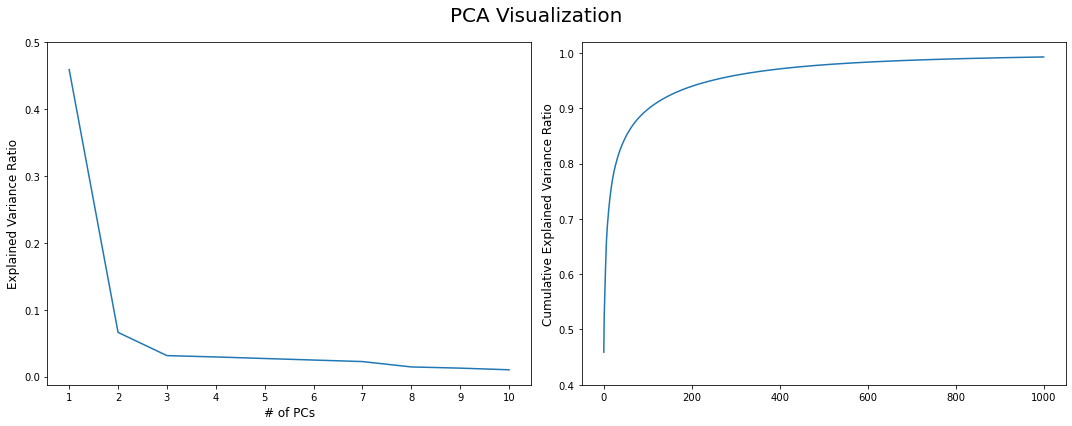

In [57]:
pcs = 10
x = np.arange(0, pcs)
x_labels = np.arange(1, pcs + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(pca.explained_variance_ratio_[:pcs])
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels)
ax1.set_yticks(np.arange(0, .6, 0.1))
ax1.set_xlabel('# of PCs', fontsize=12)
ax1.set_ylabel('Explained Variance Ratio', fontsize=12)

pcs = 1000
x = np.arange(0, pcs)
x_labels = np.arange(1, pcs + 1)

ax2.plot(cum_pcs[:pcs])
#ax2.set_xticks(x)
#ax2.set_xticklabels(x_labels)
ax1.set_xlabel('# of PCs', fontsize=12)
ax2.set_yticks(np.arange(.4, 1.1, 0.1))
ax2.set_ylabel('Cumulative Explained Variance Ratio', fontsize=12)

fig.suptitle('PCA Visualization', fontsize=20)
plt.tight_layout()
plt.show()